In [ ]:
import h5py
import yaml
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import sys
import torch
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('default')

# Load dataset exmaple

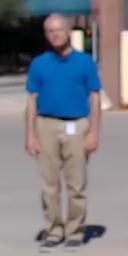

In [48]:
from PIL import Image
f = h5py.File('/data/CCVID/ccvid.h5', 'r')
f_array = np.array(f['session1/001_01/00001'][:])
f_face = h5py.File('/data/CCVID/ccvid_face.h5', 'r')
f_face_array = np.array(f_face['session1/001_01/00001/face_0'][:])

f_pil = Image.fromarray(f_array.astype(np.uint8))
f_pil

# Evaluate

In [33]:
from tools.eval_metrics import test_score, score_fusion_method, normalize_score

SEED = 45 # fix seed for reproducing the results of paper

# model_list = ['adaface', 'biggait', 'cal-ccvid']
# dataset_name = 'ccvid'

model_list = ['adaface', 'agrl', 'cal-mevid']
dataset_name = 'mevid'

# model_list = ['adaface', 'aim', 'cal-ltcc']
# dataset_name = 'ltcc'

score= h5py.File(f"./test_feats/scoremats_{dataset_name}.h5", 'r')
print(f"score_mat shape: {score[f'{model_list[0]}/score_mat'].shape}")
print(f"merge_score_mat shape: {score[f'{model_list[0]}/merge_score_mat'].shape}")
print(f"number of gallery samples: {score['g_pids'].shape}, subjects: {score['unique_g_pids'].shape}")
print(f"number of query samples: {score['q_pids'].shape}")

# load score matrices
q_pids = score['q_pids'][:].astype(int)
q_camids = score['q_camids'][:].astype(int)
q_clothes_ids = score['q_clothes_ids'][:].astype(int)
g_pids = score['g_pids'][:].astype(int)
g_camids = score['g_camids'][:].astype(int)
g_clothes_ids = score['g_clothes_ids'][:].astype(int)
unique_g_pids = score['unique_g_pids'][:].astype(int)

score_mats = {}
merge_score_mats = {}
for model_name in model_list:
    score_mats[model_name] = score[model_name]['score_mat'][:]
    merge_score_mats[model_name] = score[model_name]['merge_score_mat'][:]

score_mat shape: (316, 1438)
merge_score_mat shape: (316, 54)
number of gallery samples: (1438,), subjects: (54,)
number of query samples: (316,)


## Single model performance


In [34]:
df = pd.DataFrame()
for model_name in model_list:
    res = test_score(score_mats[model_name], merge_score_mats[model_name], q_pids, q_camids, q_clothes_ids, 
                g_pids, g_camids, g_clothes_ids, unique_g_pids, dataset=dataset_name, seed=SEED)
    df = pd.concat([df, res], axis=1)
    df.columns = df.columns[:-1].tolist() + [f'{model_name}']
df.loc[['GR_top1', 'GR_mAP', r'TAR@1.00%FAR', r'FNIR@1.00%FPIR', r'FNIR@1.00%FPIR_std', 'CC_top1', 'CC_mAP']].round(3) *100

,adaface,agrl,cal-mevid
GR_top1,25.0,51.9,52.5
GR_mAP,8.1,25.5,27.1
TAR@1.00%FAR,5.4,30.7,34.7
FNIR@1.00%FPIR,98.8,69.4,67.8
FNIR@1.00%FPIR_std,1.2,8.9,7.3
CC_top1,4.6,5.6,3.2
CC_mAP,3.2,6.0,4.3


## Traditional Score-fusion Methods

In [ ]:
# Baseline performance

fuse_score_mats = np.zeros_like(score_mats[model_name])
fuse_merge_score_mats = np.zeros_like(merge_score_mats[model_name])
#Z-Score, Min-Max
for method in ['zscore', 'minmax', 'rhe']:
    fuse_score_mats = np.zeros_like(score_mats[model_name])
    fuse_merge_score_mats = np.zeros_like(merge_score_mats[model_name])
    for model_name in model_list:
        mask = (q_pids.reshape(-1, 1) == g_pids.reshape(1, -1))
        match_scores = score_mats[model_name][mask]
        mean_match = match_scores.mean()
        std_match = match_scores.std()
        min_score = score_mats[model_name].min()
        norm_score_mat = normalize_score(score_mats[model_name], method=method, min=min_score, match_mean=mean_match, match_std=std_match)
        norm_merge_score_mat = normalize_score(merge_score_mats[model_name], method=method, min=min_score, match_mean=mean_match, match_std=std_match)

        fuse_score_mats += norm_score_mat
        fuse_merge_score_mats += norm_merge_score_mat
    fuse_score_mats /= len(model_list)
    fuse_merge_score_mats /= len(model_list)
    res = test_score(fuse_score_mats, fuse_merge_score_mats, q_pids, q_camids, q_clothes_ids, 
                g_pids, g_camids, g_clothes_ids, unique_g_pids, dataset=dataset_name, seed=SEED)
    df = pd.concat([df, res], axis=1)
    df.columns = df.columns[:-1].tolist() + [f'{method}']
    
for method in ['min', 'mean', 'max']:
    fuse_score_mats = score_fusion_method([score_mats[model_name] for model_name in model_list], method=method)
    fuse_merge_score_mats = score_fusion_method([merge_score_mats[model_name] for model_name in model_list], method=method)
    res = test_score(fuse_score_mats, fuse_merge_score_mats, q_pids, q_camids, q_clothes_ids, 
                g_pids, g_camids, g_clothes_ids, unique_g_pids, dataset=dataset_name, seed=SEED)
    df = pd.concat([df, res], axis=1)
    df.columns = df.columns[:-1].tolist() + [f'{method}']
    
df.loc[['GR_top1', 'GR_mAP', r'TAR@1.00%FAR', r'FNIR@1.00%FPIR', r'FNIR@1.00%FPIR_std', 'CC_top1', 'CC_mAP']].round(3) *100

,adaface,biggait,cal-ccvid,zscore,minmax,rhe,min,mean,max
GR_top1,94.0,76.7,81.4,92.2,91.8,91.7,87.1,92.0,89.9
GR_mAP,87.9,61.0,74.7,90.6,90.9,90.2,79.2,91.2,89.3
TAR@1.00%FAR,75.7,49.7,66.3,73.9,73.9,73.1,62.4,73.9,73.4
FNIR@1.00%FPIR,13.0,71.1,52.8,15.1,15.4,16.6,48.5,13.9,23.0
FNIR@1.00%FPIR_std,3.5,6.1,13.3,1.5,2.0,2.5,8.7,1.1,10.1
CC_top1,71.8,72.5,80.8,89.9,89.8,90.0,73.0,89.4,89.0
CC_mAP,72.0,56.1,72.8,84.6,86.2,85.0,68.5,86.9,86.7


## Ours

In [ ]:
from model import QME, MoNormQE, MoNormQE_dev


# Ours performance
backbone_cfg = yaml.safe_load(open(f'./configs/backbone_cfg-{dataset_name}.yaml', 'r'))
train_cfg = yaml.safe_load(open(f'./configs/train_cfg-{dataset_name}.yaml', 'r'))

# Adaface-QE
# ckpt_path = 'checkpoints/QME/lsf-ccvid-bs8-seq8-245.92-630.pth'
# f = h5py.File('./test_feats/mod_qe_adaface-t1r3_ccvid_3.h5', 'r')

ckpt_path = 'checkpoints/QME/lsf-mevid-bs8-seq1-52.23-300.pth'
f_face = h5py.File('./test_feats/mod_qe_adaface_t1r3_mevid_mevid_6000.h5', 'r')

# ckpt_path = 'checkpoints/QME/lsf-ltcc-bs8-seq8-84.22-3460.pth'
# f = h5py.File('./test_feats/mod_qe_adaface_t1r3_ltcc_6000.h5', 'r')

face_weights = torch.from_numpy(f_face['face_weights'][:]) # (num_q, 1)

# NOTE: model_list has to be the same sequence as the model_list in the training 
model = MoNormQE_dev(model_list=backbone_cfg['model_list'], num_experts=train_cfg['num_experts'], mlp_ratio=train_cfg['mlp_ratio'], out_dim=train_cfg['out_dim'], qe_ckpt_path=backbone_cfg['qe_ckpt_path'],
                f_patch_dim=512, g_patch_dim=384, b_patch_dim=1024, dropout_rate=train_cfg['dropout_rate'], qe_mode='adaface')
model.load_state_dict(torch.load(ckpt_path)['model_state_dict'], strict=False)
model.eval()
model.cuda()
with torch.no_grad():
    input_score_mats = {k:torch.from_numpy(v) for k, v in score_mats.items()}
    input_merge_score_mats = {k:torch.from_numpy(v) for k, v in merge_score_mats.items()}

    fuse_score_mats = model.inference(input_score_mats, face_weights, None, None)['fuse_scores'].cpu().numpy()
    fuse_merge_score_mats = model.inference(input_merge_score_mats, face_weights, None, None)['fuse_scores'].cpu().numpy()
          
our_res = test_score(fuse_score_mats, fuse_merge_score_mats, q_pids, q_camids, q_clothes_ids, 
                    g_pids, g_camids, g_clothes_ids, unique_g_pids, dataset=dataset_name, seed=SEED)
df = pd.concat([df, our_res], axis=1)
df.columns = df.columns[:-1].tolist() + ['Ours']
df.loc[['GR_top1', 'GR_mAP', r'TAR@1.00%FAR', r'FNIR@1.00%FPIR', r'FNIR@1.00%FPIR_std']].round(3) *100

initializing MoNormQE DEV model with 2 experts
initializing LSN model
using Batch Normalization
initializing LSN model
using Batch Normalization
initializing FQE model
load qe model from checkpoints/QME/fgb_mod_qe-adaface_t1r20-mevid-6000.pth


,adaface,agrl,cal-mevid,Ours,Ours
GR_top1,25.0,51.9,52.5,55.7,55.7
GR_mAP,8.1,25.5,27.1,28.2,28.2
TAR@1.00%FAR,5.4,30.7,34.7,32.9,32.9
FNIR@1.00%FPIR,98.8,69.4,67.8,64.6,64.6
FNIR@1.00%FPIR_std,1.2,8.9,7.3,8.2,8.2
